In [ ]:
from google.colab import drive  
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [2]:
!pip install https://github.com/Antonio-Ionaton/GradientCorrection/tarball/main
#!pip uninstall gradientcorrection

     \ 2.1 kB 3.3 MB/s
  Created wheel for gradientcorrection: filename=gradientcorrection-0.1-py3-none-any.whl size=2251 sha256=1df0b329df85dcfa3596c0cb2af2f113dc1481af5dc9b70bb09aa08c13af2acf
  Stored in directory: /tmp/pip-ephem-wheel-cache-szsedxki/wheels/03/4c/0a/9516d8fa386ed9a21d1aa50e8cc5b1f6d6f576195897b24409
Successfully built gradientcorrection


In [6]:
import gradientcorrection
from gradientcorrection import layers, utils, metrics, helper, explain, model_zoo, geomath

In [ ]:
!pip install logomaker
!pip install https://github.com/p-koo/tfomics/tarball/master

     |████████████████████████████████| 11.8 MB 5.0 MB/s 
     | 19 kB 1.6 MB/s
  Created wheel for tfomics: filename=tfomics-0.1.0.dev0-py3-none-any.whl size=22510 sha256=0456309adb6ef402d98b4803bf432a23c3fb6787c6446c5294751427b5a2e584
  Stored in directory: /tmp/pip-ephem-wheel-cache-7qkmk5z7/wheels/e1/eb/ae/f064df77529927df479c5f666c7572e25493375bcd4c1ff19f
Successfully built tfomics


In [ ]:
!wget https://www.dropbox.com/s/5iww0ootxkr6e21/synthetic_code_dataset.h5

--2021-10-06 21:28:48--  https://www.dropbox.com/s/5iww0ootxkr6e21/synthetic_code_dataset.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5iww0ootxkr6e21/synthetic_code_dataset.h5 [following]
--2021-10-06 21:28:48--  https://www.dropbox.com/s/raw/5iww0ootxkr6e21/synthetic_code_dataset.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd68095e31173a057e35d084b63.dl.dropboxusercontent.com/cd/0/inline/BXhlS_Ypf_cH9e--Ke8KA_FrGNfij-0v5EJnH_bRhnX3INLJqnP8xGQs-pQHWLyMnOHLYLjA_BOop8Q-cGMjG6uQLXJtjlyeAlzb2lz1JwVgyqkTW61J1q1DHOTBIArUjXknhJybXJXSWZmrKQXZSfR6/file# [following]
--2021-10-06 21:28:49--  https://ucd68095e31173a057e35d084b63.dl.dropboxusercontent.com/cd/0/inline/BXhlS_Ypf_cH9e--Ke8KA_FrGNfij-0v5EJnH_bRhnX3INLJqnP

In [ ]:
import os, h5py, sys, time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import tfomics

# Load Synthetic regulatory code data (Task 3 in Koo & Ploenzke, NMI, 2021)

In [ ]:
data_path = '.' 
filepath = os.path.join(data_path, 'synthetic_code_dataset.h5')
with h5py.File(filepath, 'r') as dataset:
    x_train = np.array(dataset['X_train']).astype(np.float32)
    y_train = np.array(dataset['Y_train']).astype(np.float32)
    x_valid = np.array(dataset['X_valid']).astype(np.float32)
    y_valid = np.array(dataset['Y_valid']).astype(np.int32)
    x_test = np.array(dataset['X_test']).astype(np.float32)
    y_test = np.array(dataset['Y_test']).astype(np.int32)
    model_test = np.array(dataset['model_test']).astype(np.float32)

model_test = model_test.transpose([0,2,1])
x_train = x_train.transpose([0,2,1])
x_valid = x_valid.transpose([0,2,1])
x_test = x_test.transpose([0,2,1])

N, L, A = x_train.shape

In [ ]:
model_names = ['cnn-dist'] #model_names = ['cnn-dist', 'cnn-local']
activations = ['relu'] # activations = ['relu', 'exponential']

results_path = utils.make_directory('drive/My Drive/results_regularized_angle', 'task3')  #utils.make_directory('../results', 'task3')
params_path = utils.make_directory(results_path, 'model_params')  #utils.make_directory(results_path, 'model_params')

#------------------------------------------------------------------------


# Useful functions from tfomics

In [ ]:
from tfomics.fit import MonitorMetrics, LRDecay, EarlyStopping, progress_bar

@tf.function
def saliency_map(X, model):
  with tf.GradientTape() as tape:
    tape.watch(X)
    outputs = model(X, training=True)[:,0]
  return tape.gradient(outputs, X)

@tf.function
def calculate_angles(saliency_score):
  orthogonal_residual = tf.reduce_sum(saliency_score, axis=-1)
  L2_norm = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(saliency_score), axis=-1))
  sine = 1/2 * orthogonal_residual / L2_norm 
  sine = tf.math.asin(sine) * tf.constant(180/3.1416) 
  return sine


class CustomTrainer():
  """Custom training loop from scratch"""

  def __init__(self, model, loss, optimizer, metrics, reg_factor=1e-4):
    self.model = model
    self.loss = loss
    self.optimizer = optimizer
    self.reg_factor = tf.constant(reg_factor)

    # metrics to monitor
    metric_names = []
    for metric in metrics:
        metric_names.append(metric)

    # class to help monitor metrics
    self.metrics = {}
    self.metrics['train'] = MonitorMetrics(metric_names, 'train')
    self.metrics['valid'] = MonitorMetrics(metric_names, 'valid')
    self.metrics['test'] = MonitorMetrics(metric_names, 'test')

  @tf.function
  def train_step(self, x, y, metrics):
    """training step for a mini-batch"""
    
    with tf.GradientTape() as tape:
      preds = self.model(x, training=True)
      loss = self.loss(y, preds)
      saliency = saliency_map(x, self.model)
      sine = calculate_angles(saliency)
      l2_norm = tf.math.sqrt(tf.reduce_sum(tf.math.square(sine), axis=-1, keepdims=True))
      total_loss = loss + self.reg_factor*tf.reduce_mean(l2_norm)
    gradients = tape.gradient(total_loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))
    metrics.update_running_metrics(y, preds)
    return loss

  @tf.function
  def test_step(self, x, y, metrics, training=False):
    """test step for a mini-batch"""
    preds = self.model(x, training=training)
    loss = self.loss(y, preds)
    metrics.update_running_metrics(y, preds)
    return loss
    

  def train_epoch(self, trainset, batch_size=128, shuffle=True, verbose=False, store=True):
    """train over all mini-batches and keep track of metrics"""

    # prepare data
    if shuffle:
      trainset.shuffle(buffer_size=batch_size)
    batch_dataset = trainset.batch(batch_size)
    num_batches = len(list(batch_dataset))

    # train loop over all mini-batches 
    start_time = time.time()
    running_loss = 0
    for i, (x, y) in enumerate(batch_dataset):      
      loss_batch = self.train_step(x, y, self.metrics['train'])
      self.metrics['train'].running_loss.append(loss_batch)
      running_loss += loss_batch
      progress_bar(i+1, num_batches, start_time, bar_length=30, loss=running_loss/(i+1))

    # store training metrics
    if store:
      if verbose:
        self.metrics['train'].update_print()
      else:
        self.metrics['train'].update()


  def evaluate(self, name, dataset, batch_size=128, verbose=True, training=False):
    """Evaluate model in mini-batches"""
    batch_dataset = dataset.batch(batch_size)
    num_batches = len(list(batch_dataset))
    for i, (x, y) in enumerate(batch_dataset):   
      loss_batch = self.test_step(x, y, self.metrics[name], training)
      self.metrics[name].running_loss.append(loss_batch)

    # store evaluation metrics
    if verbose:
      self.metrics[name].update_print()
    else:
      self.metrics[name].update()   
    

  def predict(self, x, batch_size=128):
    """Get predictions of model"""
    pred = self.model.predict(x, batch_size=batch_size)  
    return pred


  def set_early_stopping(self, patience=10, metric='loss', criterion=None):
    """set up early stopping"""
    self.early_stopping = EarlyStopping(patience=patience, metric=metric, criterion=criterion)
    

  def check_early_stopping(self, name='valid'):
    """check status of early stopping"""
    return self.early_stopping.status(self.metrics[name].get(self.early_stopping.metric)[-1])


  def set_lr_decay(self, decay_rate, patience, metric='loss', criterion=None):
    """set up learning rate decay"""
    self.lr_decay = LRDecay(optimizer=self.optimizer, decay_rate=decay_rate, 
                            patience=patience, metric=metric, criterion=criterion)

  def check_lr_decay(self, name='valid'):
    """check status and update learning rate decay"""
    self.lr_decay.check(self.metrics[name].get(self.lr_decay.metric)[-1])


  def get_metrics(self, name, metrics=None):
    """return a dictionary of metrics stored throughout training"""
    if metrics is None:
      metrics = {}
    metrics[name+'_loss'] = self.metrics[name].loss
    for metric_name in self.metrics[name].metric_names:
      metrics[name+'_'+metric_name] = self.metrics[name].get(metric_name)
    return metrics


  def set_learning_rate(self, learning_rate):
    """short-cut to set the learning rate"""
    self.optimizer.learning_rate.assign(learning_rate)



def fit_attr_prior(model, loss, optimizer, x_train, y_train, validation_data, verbose=True,  
                  metrics=['auroc', 'aupr'], num_epochs=100, batch_size=128, shuffle=True, 
                  reg_factor=1e-4, es_patience=10, es_metric='auroc', es_criterion='max',
                  lr_decay=0.3, lr_patience=3, lr_metric='auroc', lr_criterion='max'):


  # create tensorflow dataset
  trainset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  validset = tf.data.Dataset.from_tensor_slices(validation_data)

  # create trainer class
  trainer = CustomTrainer(model, loss, optimizer, metrics, reg_factor)
  trainer.set_lr_decay(decay_rate=lr_decay, patience=lr_patience, metric=lr_metric, criterion=lr_criterion)
  trainer.set_early_stopping(patience=es_patience, metric=es_metric, criterion=es_criterion)

  # train model
  for epoch in range(num_epochs):  
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))
    
    # train over epoch
    trainer.train_epoch(trainset, batch_size=batch_size, shuffle=shuffle, verbose=False)

    # validation performance
    trainer.evaluate('valid', validset, batch_size=batch_size, verbose=verbose)

    # check learning rate decay
    trainer.check_lr_decay('valid')
   
    # check early stopping
    if trainer.check_early_stopping('valid'):
      print("Patience ran out... Early stopping.")
      break
  
  # compile history
  history = trainer.get_metrics('train')
  history = trainer.get_metrics('valid', history)

  return history, trainer


# train regularized model

In [ ]:
'''num_trials = 50
activation = 'relu'
model_name = 'cnn-local'
reg_factor=2e-2   #  [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

for trial in range(num_trials):
    keras.backend.clear_session()
    model = model_zoo.cnn_local_model(activation=activation) #model = model_zoo.cnn_dist_model(activation=activation)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    loss = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0)
    history, trainer = fit_attr_prior(model, loss, optimizer, x_train, y_train, validation_data=(x_valid, y_valid), verbose=True,  
                                  metrics=['auroc', 'aupr'], num_epochs=100, batch_size=128, shuffle=True, reg_factor=reg_factor,
                                  es_patience=10, es_metric='auroc', es_criterion='max',
                                  lr_decay=0.3, lr_patience=3, lr_metric='auroc', lr_criterion='max')

    print('Saving model...') # Antonio
    # save model
    base_name = model_name+'_'+activation + '_' + str(reg_factor)
    name = base_name+'_'+str(trial)
    weights_path = os.path.join(params_path, name+'.hdf5')
    model.save_weights(weights_path)





In [ ]:
print(history['train_auroc'][-1])
print(history['valid_aupr'][-1])
print(str(reg_factor))

0.928559
0.9107173
0.02


In [ ]:
### Evaluate performance everything
from scipy import stats

mean_performance=[]
mean_interpretability_ROC=[]
mean_interpretability_PR=[]
angles_iter=[]
cosine_iter = []

num_trials = 50
activation = 'relu'
model_name = 'cnn-local'
reg_factor=1e-7   #  [1e-4, ]

for trial in range(num_trials):            
    keras.backend.clear_session()
    # load model
    model = helper.load_model(model_name, activation=activation)
    name = model_name+'_'+activation + '_' + str(reg_factor) + '_' + str(trial)  # model_name+'_'+activation+'_'+str(trial)
    print('model: ' + name)    
    # compile model
    helper.compile_model(model)
    # load model
    weights_path = os.path.join(params_path, name+'.hdf5')
    model.load_weights(weights_path)



    # predict test sequences and calculate performance metrics
    predictions = model.predict(x_test)                 
    mean_vals, std_vals = metrics.calculate_metrics(y_test, predictions, 'binary')
    mean_performance.append(mean_vals[1])

    #SALIENCY
    # number of test sequences to analyze (set this to 500 because expintgrad takes long)

    # get positive label sequences and sequence model
    pos_index = np.where(y_test[:,0] == 1)[0]   
    num_analyze = 500 # len(pos_index)
    X = x_test[pos_index[:num_analyze]]
    X_model = model_test[pos_index[:num_analyze]]
    # instantiate explainer class
    explainer = tfomics.explain.Explainer(model, class_index=0)
    saliency_scores = explainer.saliency_maps(X)    
    # reduce attribution maps to 1D scores
    sal_scores = tfomics.explain.grad_times_input(X, saliency_scores)
    # compare distribution of attribution scores at positions with and without motifs
    threshold = 0.1
    saliency_roc, saliency_pr = tfomics.evaluate.interpretability_performance(sal_scores, X_model, threshold)
    #Cosine
    #### Normalized ground truth used for Cosine metric only. (Mapped to interval [0,1]).
    X_model_normalized = X_model- 0.25  # np.swapaxes(X_model, 1,2) -0.25    #X_model here is different than in older notebooks! P.C. changed the axis it seems. 
    cosine= geomath.Scalar_product(saliency_scores, X_model_normalized) 
    cosine_iter.append(cosine)

    #Angles
    sine = np.array(calculate_angles(saliency_scores))
    na_index=np.where(np.abs(sine)>0)
    sine=sine[na_index]
    angle_std=np.std(sine)
    angles_iter.append(angle_std)

    print(mean_vals[1], np.average(saliency_roc), cosine, angle_std)
    mean_interpretability_ROC.append(np.average(saliency_roc))
    mean_interpretability_PR.append(np.average(saliency_pr))



model: cnn-local_relu_1e-07_0
0.9497980511403765 0.776445861422013 0.3566615 27.29436
model: cnn-local_relu_1e-07_1
0.9579653855529374 0.8024507508448555 0.47172514 26.95787
model: cnn-local_relu_1e-07_2
0.9465219918620422 0.7708031976030015 0.31921366 27.290726
model: cnn-local_relu_1e-07_3
0.951477270596471 0.7725330232933245 0.326213 27.109411
model: cnn-local_relu_1e-07_4
0.9607415417117213 0.7961535599017973 0.44665772 27.856184
model: cnn-local_relu_1e-07_5
0.9538352782344006 0.780264814650813 0.404232 26.530151
model: cnn-local_relu_1e-07_6
0.950809733047484 0.7676616714061951 0.37764966 28.747787
model: cnn-local_relu_1e-07_7
0.9554947465794952 0.789742372017882 0.44690457 26.32566
model: cnn-local_relu_1e-07_8
0.9535241357326352 0.7968865641492997 0.38947484 25.277184
model: cnn-local_relu_1e-07_9
0.9543531823665081 0.7745936757111028 0.40091357 27.014282
model: cnn-local_relu_1e-07_10
0.9532563706708503 0.7949502154623603 0.4003153 27.894688
model: cnn-local_relu_1e-07_11
0.9

In [ ]:
#Currently rerun and hardcoded saved to the table.  
print(np.mean(mean_performance), np.mean(mean_interpretability_ROC), np.mean(mean_interpretability_PR),  np.mean(cosine_iter))
print(np.mean(angles_iter), np.std(mean_performance), np.std(mean_interpretability_ROC), np.std(mean_interpretability_PR),  np.std(cosine_iter))


0.9527511022495014 0.7834970550731717 0.5931205785977972 0.39842927
27.63793 0.004654872082512408 0.012983840602348974 0.02426300729194796 0.04499677



# CNN-deep-relu (hardcoded data)

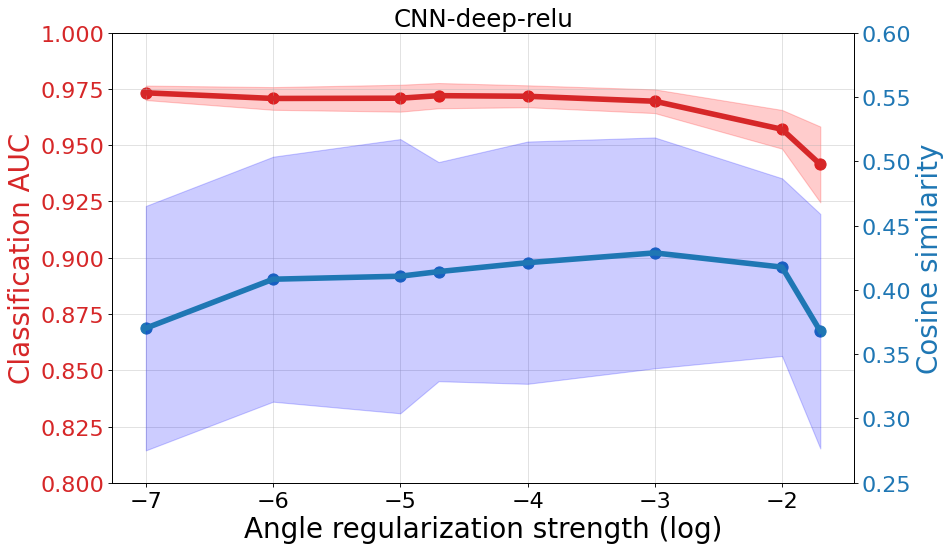

In [ ]:
# Import Data

#CNN-deep-relu MEASUREMENTS
#x = [1e-1, 5e-2, 2e-2, 1e-2, 1e-3, 1e-4, 2e-5, 1e-5, 1e-6, 1e-7(x100)]
x = [-1.698970004, -2, -3, -4, -4.698970004, -5, -6, -7]
y1 = [0.941455759, 0.957064422, 0.969532661, 0.971738883, 0.972013273, 0.970878987, 0.970767406, 0.973276337]  #Performance
y2 = [0.36785123, 0.41768402, 0.42875326, 0.42113614, 0.41418618, 0.41063312, 0.40829164, 0.3702104] #Cosine
y1errors = [0.016838232, 0.008598579, 0.005267723, 0.004863918, 0.005611217, 0.005974473, 0.0050409, 0.003213569] #Performance std
y2errors = [0.091175705, 0.06906439, 0.08975429, 0.0941875, 0.08518673, 0.10660934, 0.09524413, 0.09502306] #Cosine std

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(12,7), dpi= 80)
ax1.plot(x, y1, color='tab:red', linewidth=5.0)
ax1.scatter(x, y1, color='tab:red', s=100)
ax1.fill_between(x, np.array(y1)-np.array(y1errors), np.array(y1)+np.array(y1errors), color="r", alpha=0.2)
ax1.set_ylim(0.8,1)

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue', linewidth=5.0)
ax2.scatter(x, y2, color='tab:blue', s=100)
ax2.fill_between(x, np.array(y2)-np.array(y2errors), np.array(y2)+np.array(y2errors), color="b", alpha=0.2)
ax2.set_ylim(0.25,0.6)

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Angle regularization strength (log)', fontsize=25)
ax1.tick_params(axis='x', rotation=0, labelsize=20)
ax1.set_ylabel('Classification AUC', color='tab:red', fontsize=25)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' , labelsize=20)
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Cosine similarity", color='tab:blue', fontsize=25)
ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=20)
ax2.set_title("CNN-deep-relu", fontsize=22)
fig.tight_layout()


plt.show()

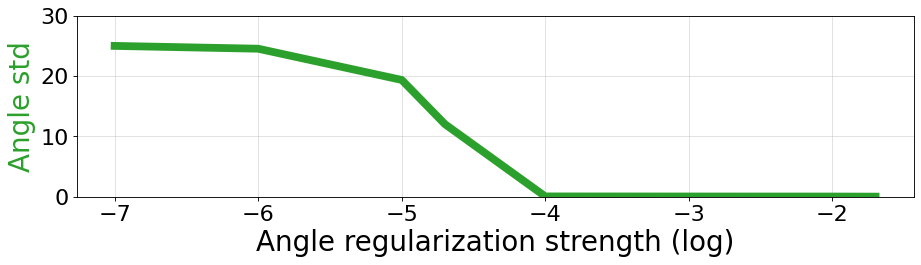

In [ ]:
# Import Data

x = [-1.698970004, -2, -3, -4, -4.698970004, -5, -6, -7]
y3 = [0.021952994, 0.03944823, 0.045315202, 0.059175, 12.023429, 19.344257, 24.513891, 24.978815]


# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(13.5,3), dpi= 80)
ax1.plot(x, y3, color='tab:green', linewidth=7.0)
ax1.set_ylim(0,30)

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Angle regularization strength (log)', fontsize=25)
ax1.tick_params(axis='x', rotation=0, labelsize=20)
ax1.set_ylabel('Angle std', color='tab:green', fontsize=25)
ax1.tick_params(axis='y', rotation=0, labelsize=20)
ax1.grid(alpha=.4)

plt.show()

# CNN-local-relu (hardcoded data)

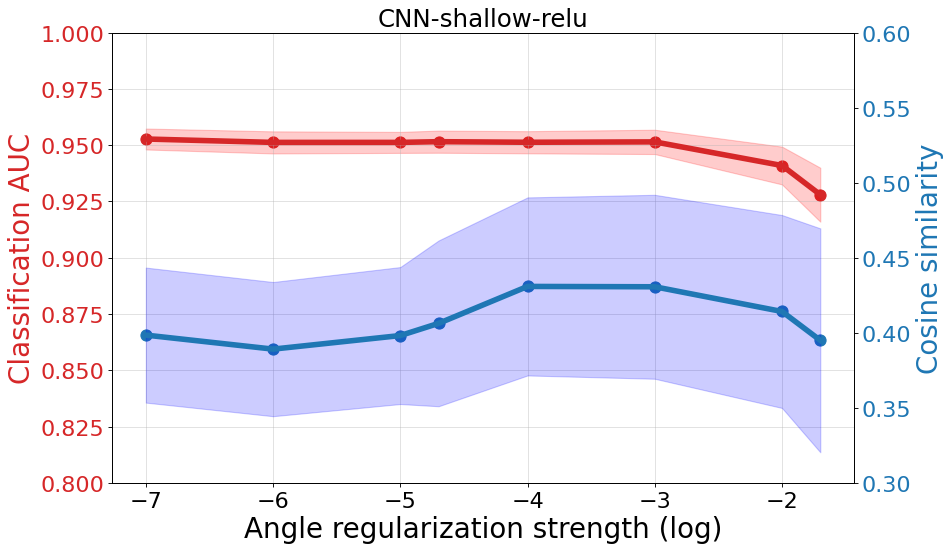

In [ ]:
# Import Data

#CNN-shallow-relu MEASUREMENTS
#x = [1e-1, 5e-2, 2e-2, 1e-2, 1e-3, 1e-4, 2e-5, 1e-5, 1e-6, 1e-7(x100)]
x = [-1.698970004, -2, -3, -4, -4.698970004, -5, -6, -7]
y1 = [0.92799886, 0.940968217, 0.951470008, 0.951302931, 0.951561218, 0.951244743, 0.951240562, 0.952751102]  #Performance
y2 = [0.39493778, 0.41415825, 0.43063313, 0.4308692, 0.40624648, 0.3981281, 0.38908222, 0.39842927] #Cosine
y1errors = [0.011993694, 0.008396683, 0.005403387, 0.004928373, 0.004923825, 0.004668332, 0.004910859, 0.004654872] #Performance std
y2errors = [0.074616134, 0.06428796, 0.061298102, 0.05933602, 0.055241477, 0.045641657, 0.044715315, 0.04499677] #Cosine std

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(12,7), dpi= 80)
ax1.plot(x, y1, color='tab:red', linewidth=5.0)
ax1.scatter(x, y1, color='tab:red', s=100)
ax1.fill_between(x, np.array(y1)-np.array(y1errors), np.array(y1)+np.array(y1errors), color="r", alpha=0.2)
ax1.set_ylim(0.8,1)

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue', linewidth=5.0)
ax2.scatter(x, y2, color='tab:blue', s=100)
ax2.fill_between(x, np.array(y2)-np.array(y2errors), np.array(y2)+np.array(y2errors), color="b", alpha=0.2)
ax2.set_ylim(0.3,0.6)

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Angle regularization strength (log)', fontsize=25)
ax1.tick_params(axis='x', rotation=0, labelsize=20)
ax1.set_ylabel('Classification AUC', color='tab:red', fontsize=25)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' , labelsize=20)
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Cosine similarity", color='tab:blue', fontsize=25)
ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=20)
ax2.set_title("CNN-shallow-relu", fontsize=22)
fig.tight_layout()


plt.show()

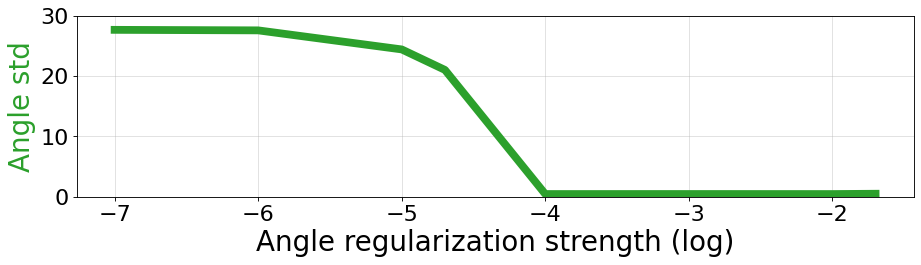

In [ ]:
x = [-1.698970004, -2, -3, -4, -4.698970004, -5, -6, -7]
y3 = [0.49968395, 0.45052144, 0.45709625, 0.4516125, 21.005564, 24.396841, 27.551672, 27.63793]


# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(13.5,3), dpi= 80)
ax1.plot(x, y3, color='tab:green', linewidth=7.0)
ax1.set_ylim(0,30)

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Angle regularization strength (log)', fontsize=25)
ax1.tick_params(axis='x', rotation=0, labelsize=20)
ax1.set_ylabel('Angle std', color='tab:green', fontsize=25)
ax1.tick_params(axis='y', rotation=0, labelsize=20)
ax1.grid(alpha=.4)

plt.show()

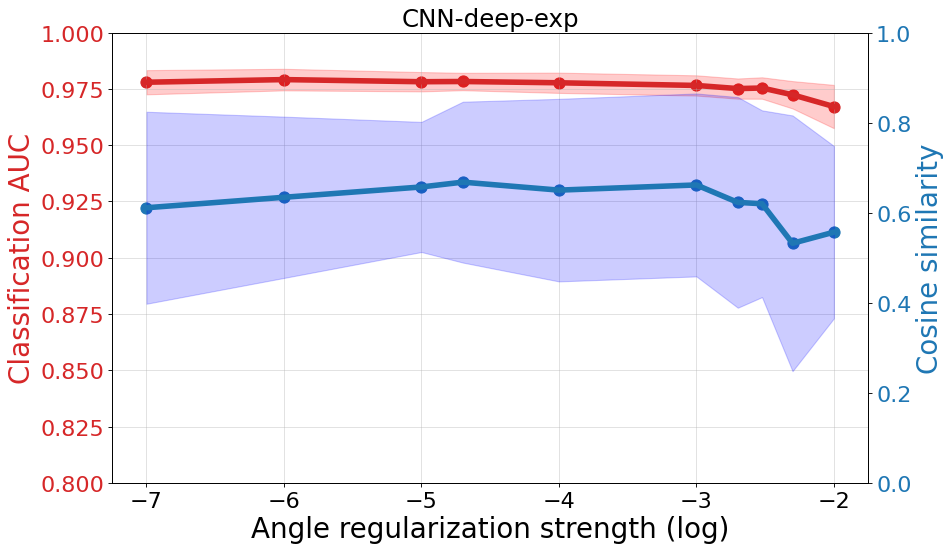

In [ ]:
# (modeli na drugom Driveu, ovo je iz Excela)

#CNN-deep-exp MEASUREMENTS
#x = [1e-1, 5e-2, 2e-2, 1e-2, 1e-3, 1e-4, 2e-5, 1e-5, 1e-6, 1e-7(x100)]
x = [-2, -2.301029996, -2.522878745, -2.698970004, -3, -4, -4.698970004, -5, -6, -7]
y1 = [0.96716243, 0.972398452, 0.975408827, 0.97515258, 0.976547566, 0.977736085, 0.978302267, 0.978198371, 0.97915039, 0.977977241]  #Performance
y2 = [0.5567677, 0.5320687, 0.6199497, 0.62290037, 0.6616843, 0.6501758, 0.66792977, 0.6572229, 0.6342612, 0.6110146] #Cosine
y1errors = [0.009620766, 0.006082432, 0.004761599, 0.004486253, 0.004500089, 0.004503273, 0.003866931, 0.004293372, 0.004789531, 0.005377678] #Performance std
y2errors = [0.19145621, 0.2840372, 0.20744507, 0.2339909, 0.20321482, 0.20278588, 0.1786776, 0.14451955, 0.17917383, 0.21328825] #Cosine std

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(12,7), dpi= 80)
ax1.plot(x, y1, color='tab:red', linewidth=5.0)
ax1.scatter(x, y1, color='tab:red', s=100)
ax1.fill_between(x, np.array(y1)-np.array(y1errors), np.array(y1)+np.array(y1errors), color="r", alpha=0.2)
ax1.set_ylim(0.8,1)

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue', linewidth=5.0)
ax2.scatter(x, y2, color='tab:blue', s=100)
ax2.fill_between(x, np.array(y2)-np.array(y2errors), np.array(y2)+np.array(y2errors), color="b", alpha=0.2)
ax2.set_ylim(0,1.0)

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Angle regularization strength (log)', fontsize=25)
ax1.tick_params(axis='x', rotation=0, labelsize=20)
ax1.set_ylabel('Classification AUC', color='tab:red', fontsize=25)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' , labelsize=20)
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Cosine similarity", color='tab:blue', fontsize=25)
ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=20)
ax2.set_title("CNN-deep-exp", fontsize=22)
fig.tight_layout()


plt.show()

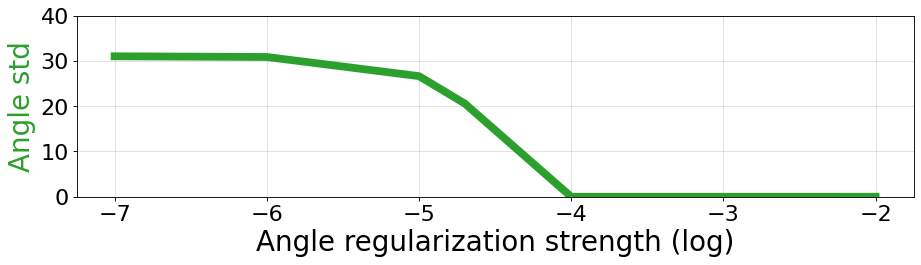

In [ ]:
x = [-2, -2.301029996, -2.522878745, -2.698970004, -3, -4, -4.698970004, -5, -6, -7]
y3 = [0.005676268, 0.002867009, 0.002807614, 0.004346054, 0.004200131, 0.003103627, 20.577852, 26.632734, 30.860018, 31.013243]


# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(13.5,3), dpi= 80)
ax1.plot(x, y3, color='tab:green', linewidth=7.0)
ax1.set_ylim(0,40)

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Angle regularization strength (log)', fontsize=25)
ax1.tick_params(axis='x', rotation=0, labelsize=20)
ax1.set_ylabel('Angle std', color='tab:green', fontsize=25)
ax1.tick_params(axis='y', rotation=0, labelsize=20)
ax1.grid(alpha=.4)

plt.show()

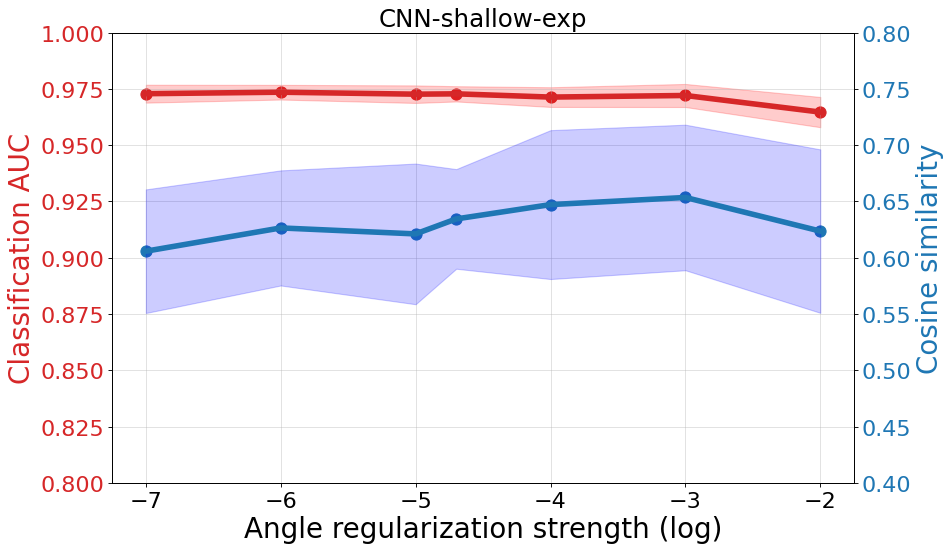

In [ ]:
# (modeli na drugom Driveu, ovo je iz Excela)

#CNN-shallow-exp MEASUREMENTS
x = [-2, -3, -4, -4.698970004, -5, -6, -7]
y1 = [0.964711363, 0.972088435, 0.97137699, 0.972821346, 0.972669568, 0.973545414, 0.972880942]  #Performance
y2 = [0.6236587, 0.6535451, 0.647211, 0.63448215, 0.6211646, 0.62647396, 0.6057976] #Cosine
y1errors = [0.006718292, 0.005123571, 0.004378859, 0.003393487, 0.003897482, 0.003258382, 0.003977907] #Performance std
y2errors = [0.0726126, 0.06467024, 0.066156976, 0.0442635, 0.062501855, 0.051141087, 0.05492181] #Cosine std

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(12,7), dpi= 80)
ax1.plot(x, y1, color='tab:red', linewidth=5.0)
ax1.scatter(x, y1, color='tab:red', s=100)
ax1.fill_between(x, np.array(y1)-np.array(y1errors), np.array(y1)+np.array(y1errors), color="r", alpha=0.2)
ax1.set_ylim(0.8,1)

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue', linewidth=5.0)
ax2.scatter(x, y2, color='tab:blue', s=100)
ax2.fill_between(x, np.array(y2)-np.array(y2errors), np.array(y2)+np.array(y2errors), color="b", alpha=0.2)
ax2.set_ylim(0.4,0.8)

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Angle regularization strength (log)', fontsize=25)
ax1.tick_params(axis='x', rotation=0, labelsize=20)
ax1.set_ylabel('Classification AUC', color='tab:red', fontsize=25)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' , labelsize=20)
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Cosine similarity", color='tab:blue', fontsize=25)
ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=20)
ax2.set_title("CNN-shallow-exp", fontsize=22)
fig.tight_layout()


plt.show()

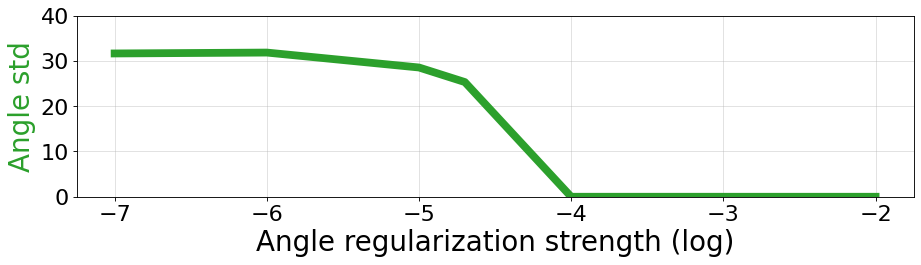

In [ ]:
x = [-2, -3, -4, -4.698970004, -5, -6, -7]
y3 = [0.002455039, 0.002696348, 0.003887756, 25.325163, 28.538591, 31.835224, 31.638182]


# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(13.5,3), dpi= 80)
ax1.plot(x, y3, color='tab:green', linewidth=7.0)
ax1.set_ylim(0,40)

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Angle regularization strength (log)', fontsize=25)
ax1.tick_params(axis='x', rotation=0, labelsize=20)
ax1.set_ylabel('Angle std', color='tab:green', fontsize=25)
ax1.tick_params(axis='y', rotation=0, labelsize=20)
ax1.grid(alpha=.4)

plt.show()

# **INITIALIZATIONS OFFICIAL**

# Vary initializations for CNNs

In [ ]:
# New, initialization folder 

results_path = utils.make_directory('drive/My Drive/results_initialization_angle', 'task3')  #utils.make_directory('../results', 'task3')
params_path = utils.make_directory(results_path, 'model_params')  #utils.make_directory(results_path, 'model_params')

#------------------------------------------------------------------------

In [ ]:
sigmas = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]

results = []
sines = []
for sigma in sigmas:
  model = cnn_local_init_model(activation='relu', sigma=sigma)  #cnn_dist_init_model

  # set up optimizer and metrics
  auroc = keras.metrics.AUC(curve='ROC', name='auroc')
  aupr = keras.metrics.AUC(curve='PR', name='aupr')
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  loss = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0)
  model.compile(optimizer=optimizer, loss=loss, metrics=[auroc, aupr])


  # early stopping callback
  es_callback = keras.callbacks.EarlyStopping(monitor='val_auroc', 
                                              patience=10, 
                                              verbose=1, 
                                              mode='max', 
                                              restore_best_weights=True)
  # reduce learning rate callback
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_auroc', 
                                                  factor=0.2,
                                                  patience=4, 
                                                  min_lr=1e-7,
                                                  mode='max',
                                                  verbose=1) 

  # train model
  history = model.fit(x_train, y_train, 
                      epochs=100,
                      batch_size=100, 
                      shuffle=True,
                      validation_data=(x_valid, y_valid), 
                      callbacks=[es_callback, reduce_lr])

  # test model 
  vals = model.evaluate(x_test, y_test)

  # get positive label sequences and sequence model
  pos_index = np.where(y_test[:,0] == 1)[0]   

  num_analyze = len(pos_index)
  X = x_test[pos_index[:num_analyze]]
  X_model = model_test[pos_index[:num_analyze]]

  # instantiate explainer class
  explainer = tfomics.explain.Explainer(model, class_index=0)
  saliency_scores = explainer.saliency_maps(X)
  sine = calculate_angles(saliency_scores)

  results.append(vals[1])
  sines.append(sine)

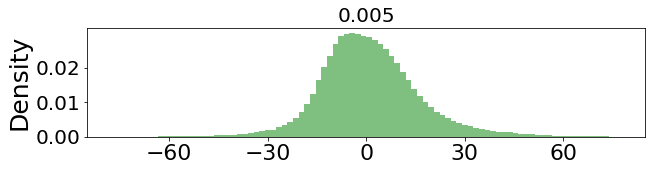

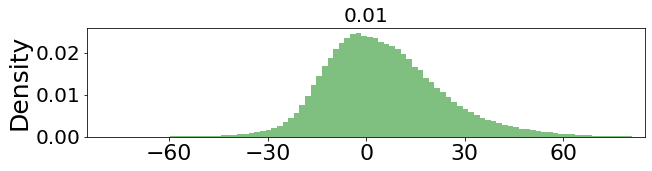

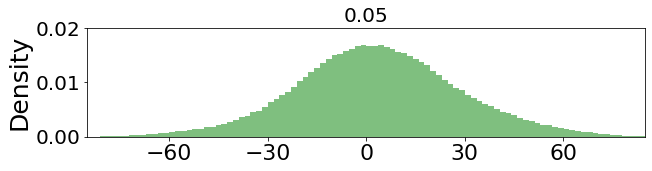

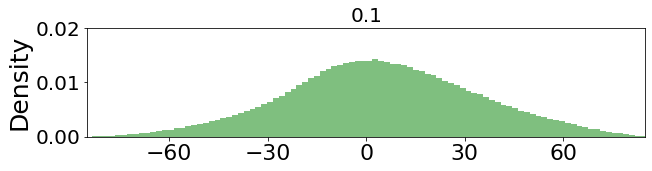

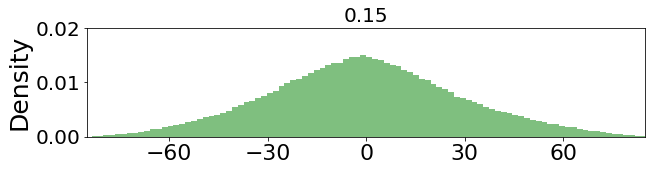

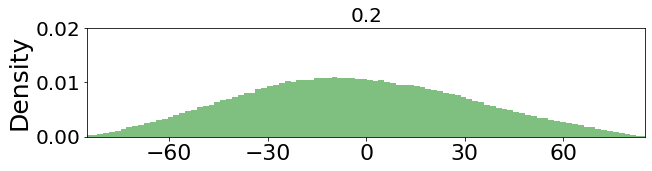

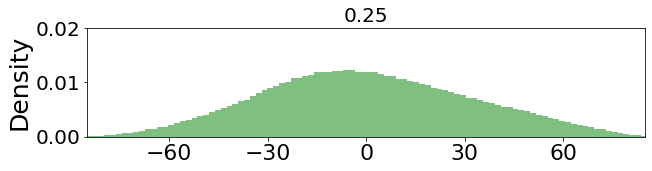

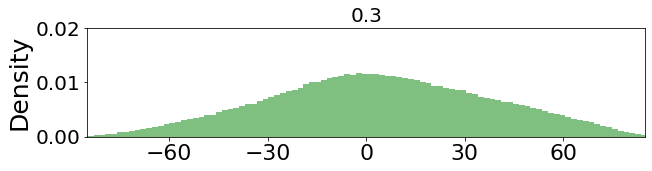

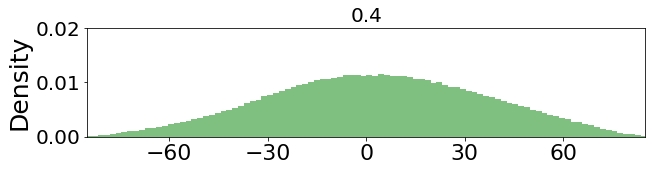

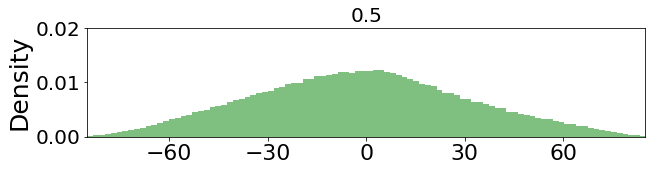

In [ ]:
for i, sigma in enumerate(sigmas):
  plt.figure(figsize=(10,2))
  plt.hist(np.reshape(sines[i],[-1]), 100, density=True, alpha=0.5, color='g')
  plt.ylabel('Density', fontsize=25)
  plt.xticks([-60, -30, 0, 30, 60], fontsize=22)
  #plt.tick_params(axis='x',  which='both', bottom=False,  top=False, labelbottom=False) 
  plt.yticks(ticks=[0.0, 0.01, 0.02], fontsize=20)
  plt.xlim([-85, 85])
  plt.title(sigma, fontsize=20)

Text(0.5, 0, 'Std of initialization')

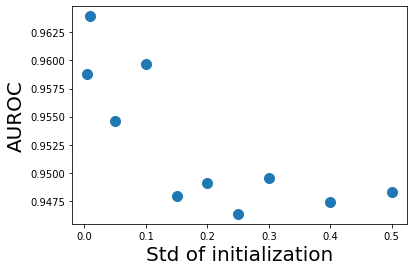

In [ ]:
plt.figure()
plt.scatter(sigmas, results, 100)
plt.ylabel('AUROC', fontsize=20)
plt.xlabel('Std of initialization', fontsize=20)

Text(0.5, 0, 'Std of initialization')

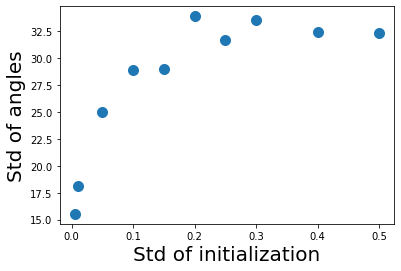

In [ ]:
vals = []
for sine in sines:
  vals.append(np.nanstd(np.reshape(sine,[-1])))

plt.figure()
plt.scatter(sigmas, vals, 100)
plt.ylabel('Std of angles', fontsize=20)
plt.xlabel('Std of initialization', fontsize=20)

In [ ]:
print(sigmas)
print(results)
print(vals)

[0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
[0.9587583541870117, 0.9639285206794739, 0.9545794129371643, 0.9597026109695435, 0.9479733109474182, 0.9490560293197632, 0.9463462233543396, 0.9495469331741333, 0.9473856091499329, 0.9482532143592834]
[15.527712, 18.09093, 24.989695, 28.878414, 28.976164, 33.89802, 31.667248, 33.503315, 32.46815, 32.353947]


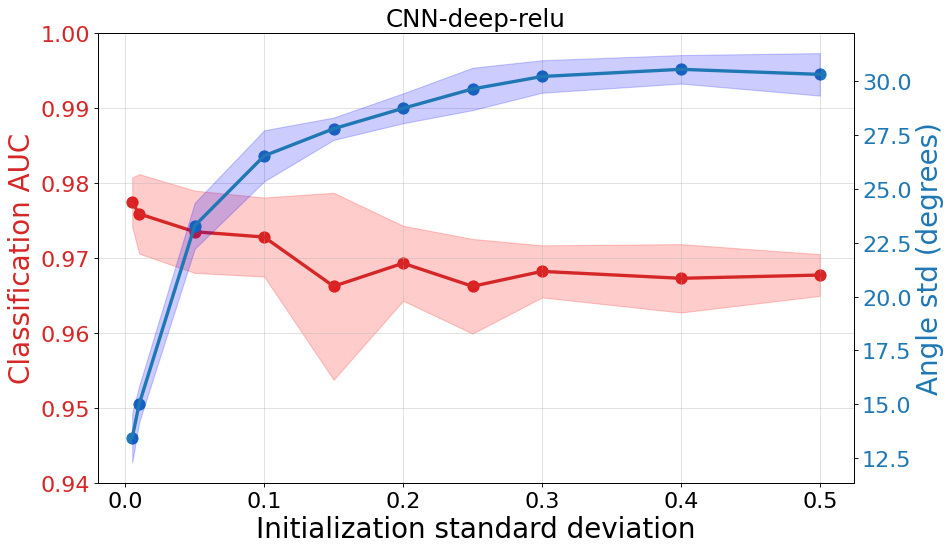

In [ ]:
#CNN-deep-relu MEASUREMENTS
x = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
y1 = [0.977385879,	0.975845879,	0.973460376,	0.972756481,	0.966193831,	0.969264859,	0.966191173,	0.968178767,	0.967256445,	0.967690569]
y2 = [13.4443801,	15.0040533,	23.288477,	26.5384581,	27.7966209,	28.7459983,	29.6453104,	30.2235584,	30.5575072,	30.3226116]
y1errors = [0.00329961,	0.005298933,	0.005484404,	0.005272522,	0.012466105,	0.00499779,	0.006313082,	0.003472151,	0.004557165,	0.002783571]
y2errors = [1.14796265,	0.847146792,	1.068551975,	1.187178647,	0.519849928,	0.695600589,	0.98486642,	0.755919426,	0.661775351,	0.986964994]


# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(12,7), dpi= 80)
ax1.plot(x, y1, color='tab:red', linewidth=3.0)
ax1.scatter(x, y1, color='tab:red', s=100)
ax1.fill_between(x, np.array(y1)-np.array(y1errors), np.array(y1)+np.array(y1errors), color="r", alpha=0.2)
ax1.set_ylim(0.94,1)

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue', linewidth=3.0)
ax2.scatter(x, y2, color='tab:blue', s=100)
ax2.fill_between(x, np.array(y2)-np.array(y2errors), np.array(y2)+np.array(y2errors), color="b", alpha=0.2)


# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Initialization standard deviation', fontsize=25)
ax1.tick_params(axis='x', rotation=0, labelsize=20)
ax1.set_ylabel('Classification AUC', color='tab:red', fontsize=25)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' , labelsize=20)
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Angle std (degrees)", color='tab:blue', fontsize=25)
ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=20)
ax2.set_title("CNN-deep-relu", fontsize=22)
fig.tight_layout()


plt.show()

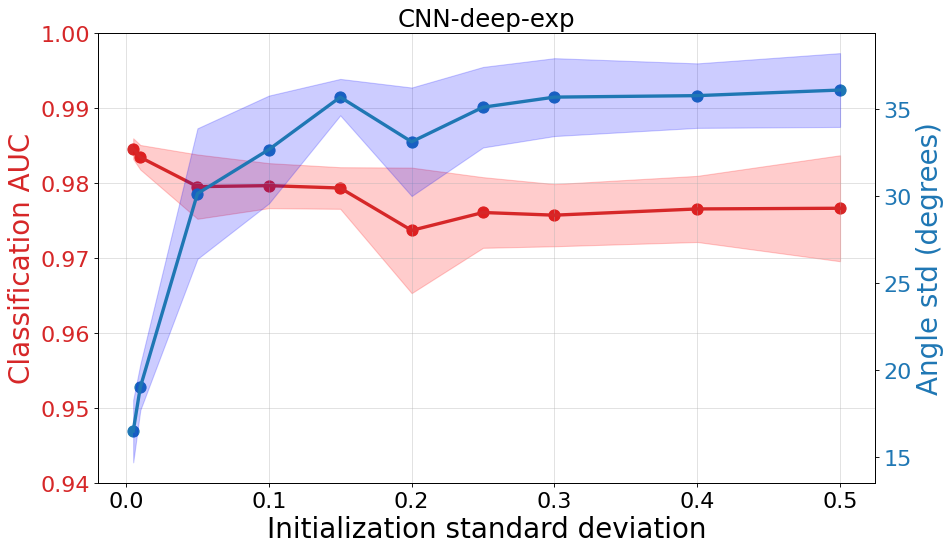

In [ ]:
#CNN-deep-exp MEASUREMENTS
x = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
y1 = [0.984536362,	0.983387083,	0.979475796,	0.979608923,	0.979292452,	0.973644722,	0.976028568,	0.975671357,	0.976503724,	0.976593143]
y2 = [16.4961478,	19.0228494,	30.1323824,	32.6618309,	35.6709932,	33.1078042,	35.0929972,	35.6719801,	35.7570316,	36.0783778]
y1errors = [0.001382438,	0.001639416,	0.004285549,	0.003000942,	0.002773293,	0.008366461,	0.004708231,	0.004144206,	0.004408311,	0.007061593]
y2errors = [1.789812567,	1.311050324,	3.748168726,	3.096724594,	1.045541283,	3.114176718,	2.310827383,	2.235712843,	1.85155239,	2.118819679]


# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(12,7), dpi= 80)
ax1.plot(x, y1, color='tab:red', linewidth=3.0)
ax1.scatter(x, y1, color='tab:red', s=100)
ax1.fill_between(x, np.array(y1)-np.array(y1errors), np.array(y1)+np.array(y1errors), color="r", alpha=0.2)
ax1.set_ylim(0.94,1)

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue', linewidth=3.0)
ax2.scatter(x, y2, color='tab:blue', s=100)
ax2.fill_between(x, np.array(y2)-np.array(y2errors), np.array(y2)+np.array(y2errors), color="b", alpha=0.2)
#ax2.set_ylim(10,40)

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Initialization standard deviation', fontsize=25)
ax1.tick_params(axis='x', rotation=0, labelsize=20)
ax1.set_ylabel('Classification AUC', color='tab:red', fontsize=25)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' , labelsize=20)
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Angle std (degrees)", color='tab:blue', fontsize=25)
ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=20)
ax2.set_title("CNN-deep-exp", fontsize=22)
fig.tight_layout()


plt.show()

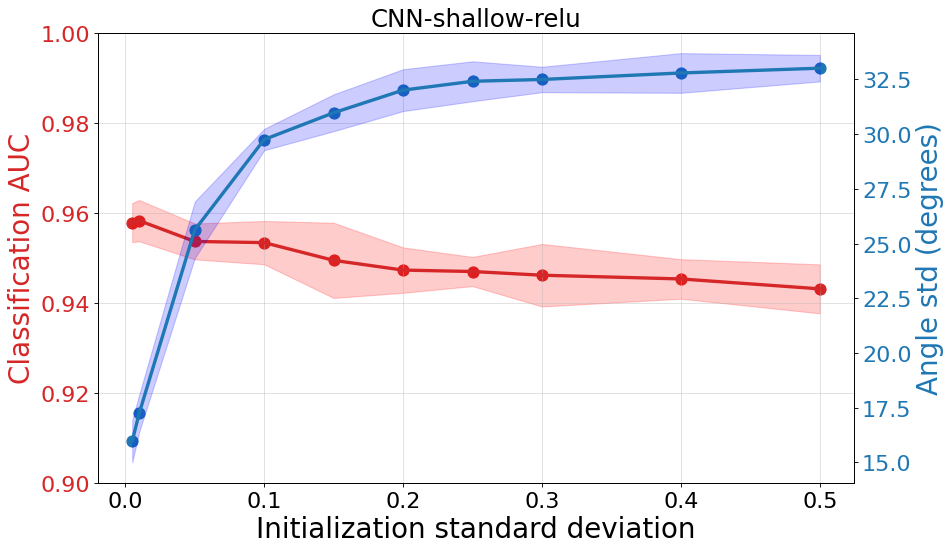

In [ ]:
#CNN-shallow-relu MEASUREMENTS
x = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
y1 = [0.957808936,	0.95824104,	0.953616256,	0.953354681,	0.949413478,	0.947250986,	0.946935505,	0.946113449,	0.945286953,	0.943084741]
y2 = [15.9719889,	17.2437059,	25.6239158,	29.7531809,	30.975878,	32.0099636,	32.4141391,	32.4971593,	32.7941062,	33.0116204]
y1errors = [0.004357101,	0.004578092,	0.003988269,	0.004813586,	0.008351106,	0.005039053,	0.003243078,	0.006949387,	0.004396892,	0.005442975]
y2errors = [0.966756649,	0.851302164,	1.293041442,	0.488405223,	0.842920007,	0.955953289,	0.912840252,	0.58097429,	0.906562938,	0.605719752]


# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(12,7), dpi= 80)
ax1.plot(x, y1, color='tab:red', linewidth=3.0)
ax1.scatter(x, y1, color='tab:red', s=100)
ax1.fill_between(x, np.array(y1)-np.array(y1errors), np.array(y1)+np.array(y1errors), color="r", alpha=0.2)
ax1.set_ylim(0.90,1)

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue', linewidth=3.0)
ax2.scatter(x, y2, color='tab:blue', s=100)
ax2.fill_between(x, np.array(y2)-np.array(y2errors), np.array(y2)+np.array(y2errors), color="b", alpha=0.2)


# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Initialization standard deviation', fontsize=25)
ax1.tick_params(axis='x', rotation=0, labelsize=20)
ax1.set_ylabel('Classification AUC', color='tab:red', fontsize=25)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' , labelsize=20)
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Angle std (degrees)", color='tab:blue', fontsize=25)
ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=20)
ax2.set_title("CNN-shallow-relu", fontsize=22)
fig.tight_layout()


plt.show()

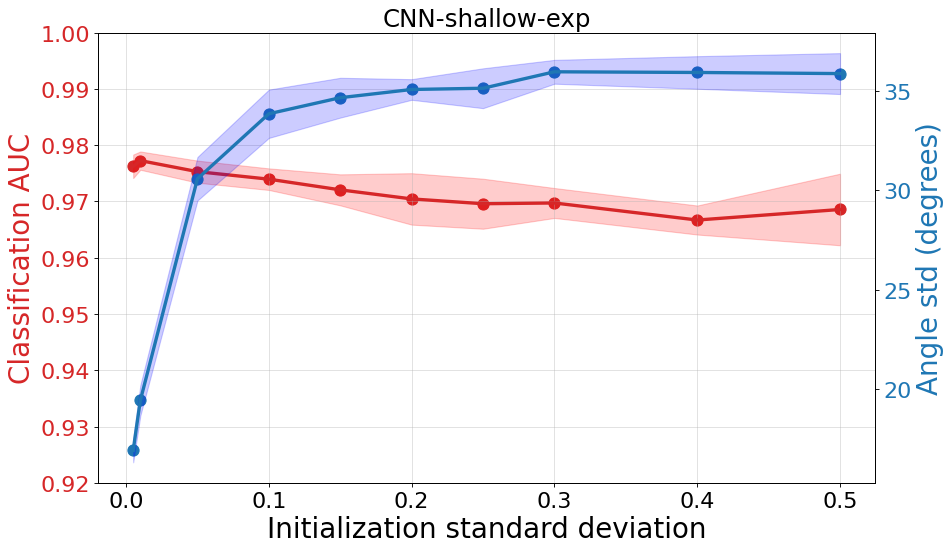

In [ ]:
#CNN-shallow-relu MEASUREMENTS
x = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
y1 = [0.976244754,	0.977258927,	0.975298488,	0.973961371,	0.972063446,	0.970451826,	0.969597644,	0.969728482,	0.966699582,	0.968572628]
y2 = [16.921186,	19.4312907,	30.5752002,	33.8416041,	34.6494253,	35.0626874,	35.1252886,	35.9522025,	35.9180538,	35.8621153]
y1errors = [0.00208813,	0.001625372,	0.001962675,	0.00191866,	0.002756653,	0.004572745,	0.004446058,	0.002660308,	0.002578597,	0.006362548]
y2errors = [0.601094911,	0.76449325,	1.093259306,	1.214353221,	1.000542485,	0.51873713,	1.001977407,	0.599230399,	0.819367983,	1.028138891]


# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(12,7), dpi= 80)
ax1.plot(x, y1, color='tab:red', linewidth=3.0)
ax1.scatter(x, y1, color='tab:red', s=100)
ax1.fill_between(x, np.array(y1)-np.array(y1errors), np.array(y1)+np.array(y1errors), color="r", alpha=0.2)
ax1.set_ylim(0.92,1)

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue', linewidth=3.0)
ax2.scatter(x, y2, color='tab:blue', s=100)
ax2.fill_between(x, np.array(y2)-np.array(y2errors), np.array(y2)+np.array(y2errors), color="b", alpha=0.2)


# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Initialization standard deviation', fontsize=25)
ax1.tick_params(axis='x', rotation=0, labelsize=20)
ax1.set_ylabel('Classification AUC', color='tab:red', fontsize=25)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' , labelsize=20)
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Angle std (degrees)", color='tab:blue', fontsize=25)
ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=20)
ax2.set_title("CNN-shallow-exp", fontsize=22)
fig.tight_layout()


plt.show()

# Chip-Seq 10 proteins Initialization. Task reduced only to deep-exp, for the paper.

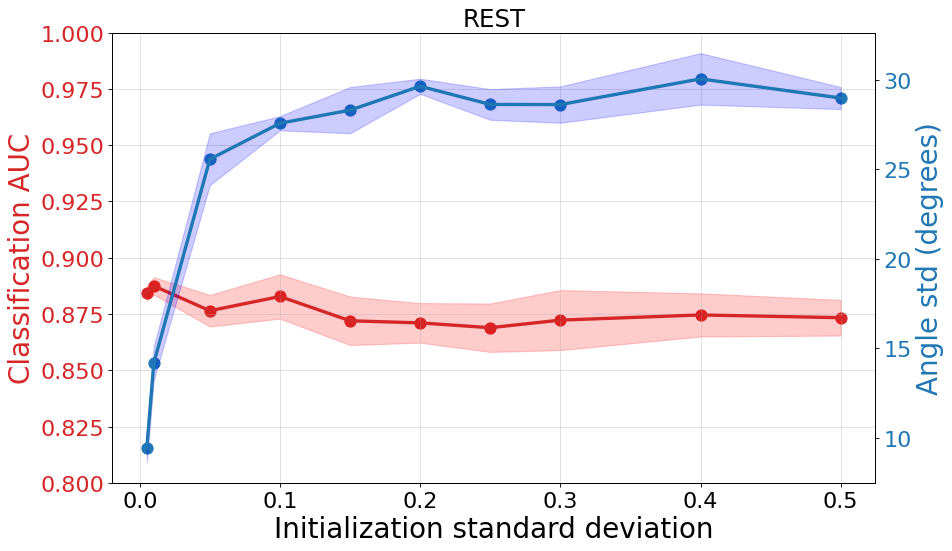

In [ ]:
#  REST protein (CNN-deep-relu) 
x = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
y1 = [0.884332026,	0.887457254,	0.876440098,	0.88278037,	0.87198105,	0.871042788,	0.868905778,	0.87228061,	0.87457262,	0.87335078]
y2 = [9.42201092,	14.175676,	25.5664604,	27.5760078,	28.3065808,	29.642283,	28.625203,	28.6185468,	30.0541448,	28.9842398]
y1errors = [0.0032576,	0.00387399,	0.007031218,	0.009837693,	0.01077956,	0.008796218,	0.010759835,	0.013346768,	0.009592254,	0.007928723]
y2errors = [0.790003093,	0.939499238,	1.447463128,	0.397505849,	1.290961746,	0.42311089,	0.857173383,	1.017956056,	1.438682709,	0.617930101]


# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(12,7), dpi= 80)
ax1.plot(x, y1, color='tab:red', linewidth=3.0)
ax1.scatter(x, y1, color='tab:red', s=100)
ax1.fill_between(x, np.array(y1)-np.array(y1errors), np.array(y1)+np.array(y1errors), color="r", alpha=0.2)
ax1.set_ylim(0.80,1)

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue', linewidth=3.0)
ax2.scatter(x, y2, color='tab:blue', s=100)
ax2.fill_between(x, np.array(y2)-np.array(y2errors), np.array(y2)+np.array(y2errors), color="b", alpha=0.2)


# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Initialization standard deviation', fontsize=25)
ax1.tick_params(axis='x', rotation=0, labelsize=20)
ax1.set_ylabel('Classification AUC', color='tab:red', fontsize=25)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' , labelsize=20)
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Angle std (degrees)", color='tab:blue', fontsize=25)
ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=20)
ax2.set_title("REST", fontsize=22)
fig.tight_layout()


plt.show()